In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import utils

from sklearn.preprocessing import OneHotEncoder


# Load data

In [2]:
colnames = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
df_monk1_train = pd.read_csv("./data/MONK/monks-1.train", sep = " ", skipinitialspace=True, names = colnames)
df_monk1_train.drop('id', axis = 1, inplace = True)
df_monk1_test = pd.read_csv("./data/MONK/monks-1.test", sep = " ", skipinitialspace=True, names = colnames)
df_monk1_test.drop('id', axis = 1, inplace = True)
df_monk1_train.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1


In [3]:
#get attributes and target values
X_all = df_monk1_train.iloc[:, 1:7].values
y_all = df_monk1_train.iloc[:, 0].values
X_test = df_monk1_test.iloc[:, 1:7].values
y_test = df_monk1_test.iloc[:, 0].values

# One hot encoding 

In [4]:
def one_hot_encoder(X_all, X_test):
    enc_all = OneHotEncoder()
    enc_all.fit(X_all)
    X_all = enc_all.transform(X_all).toarray()
    
    enc_test = OneHotEncoder()
    enc_test.fit(X_test)
    X_test = enc_test.transform(X_test).toarray()
    return X_all, X_test

# Shuffle data

In [5]:
from sklearn.utils import shuffle
X_all, y_all = shuffle(X_all, y_all)
X_all, X_test = one_hot_encoder(X_all, X_test)
val_size =int(0.2 * len(X_all))
X_val = X_all[:val_size]
y_val = y_all[:val_size]
X_train = X_all[val_size:]
y_train = y_all[val_size:]
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)
print(X_train[0])

(24, 17)
(100, 17)
(432, 17)
[0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.]


# Define the model

In [6]:
#define a model architecture and set the ranges for the values of the hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(layers.Dense(hp.Int('units', min_value=3, max_value=15, step=3), activation='relu'))
    model.add(layers.Dense(1, activation="sigmoid"))
    hp_learning_rate = hp.Float('learning_rate', min_value=0.01, max_value=1, step=0.02)
    hp_momentum = hp.Choice('momentum', values=[0.8, 0.85, 0.9, 0.95])
    model.compile(optimizer=optimizers.SGD(learning_rate=hp_learning_rate, momentum=hp_momentum), loss='mse', metrics=['accuracy'])
    return model


build_model(kt.HyperParameters())


In [7]:
tuner = kt.RandomSearch(
    hypermodel = build_model,
    #MyHyperModel(),
    objective='val_loss',
    max_trials=100,
    overwrite=True,
)
tuner.search_space_summary()


Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 15, 'step': 3, 'sampling': None}
learning_rate (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 1.0, 'step': 0.02, 'sampling': None}
momentum (Choice)
{'default': 0.8, 'conditions': [], 'values': [0.8, 0.85, 0.9, 0.95], 'ordered': True}


In [8]:
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=150, verbose=0, batch_size=32, validation_data=(X_val, y_val) )
#tuner.search(X_train, y_train, epochs=150, batch_size=10, callbacks=[stop_early], verbose=0,  validation_data=(X_val, y_val) )
#hypermodel = MyHyperModel()
hyperparameters = tuner.get_best_hyperparameters()[0]
#model = tuner.hypermodel.build(hyperparameters)
#model = hypermodel.build(hyperparameters)

model = build_model(hyperparameters)
model.build(input_shape=(None, 17))
print(model.summary())
print(hyperparameters.get('learning_rate'))
print(hyperparameters.get('momentum'))


INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 9)                 162       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 10        
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________
None
0.7699999999999999
0.9


In [9]:
train_loss = []
test_loss =[]
train_acc = []
test_acc = []

for i in range(150):
    history = model.fit( X_all, y_all, batch_size=32, verbose=0)
    train_loss.append(history.history['loss'])
    train_acc.append(history.history['accuracy'])
    score = model.evaluate(X_test, y_test)
    test_loss.append(score[0])
    test_acc.append(score[1])


14/14 [==============================] - 0s 6ms/step - loss: 0.0012 - accuracy: 1.0000


loss and accuracy on training
[3.943542833440006e-05]
[1.0]
loss and accuracy on tes
0.0011839354410767555
1.0


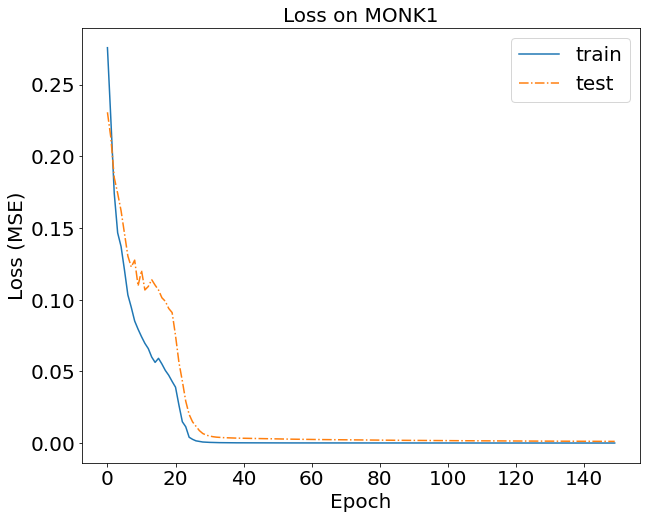

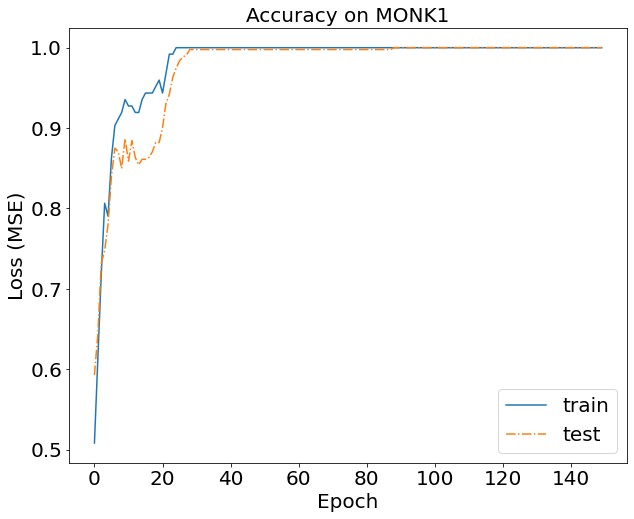

In [10]:
print("loss and accuracy on training")
print(train_loss[149])
print(train_acc[149])
print("loss and accuracy on tes")
print(test_loss[149])
print(test_acc[149])

plt.figure(figsize=(10,8))
plt.plot(train_loss, '-', label='train')
plt.plot(test_loss, '-.', label='test')
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Loss (MSE)', fontsize=20) 
plt.xlabel('Epoch', fontsize=20);
plt.title('Loss on MONK1', fontsize=20)
plt.show()

plt.figure(figsize=(10,8))
plt.plot(train_acc, '-', label='train')
plt.plot(test_acc, '-.', label='test')
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Loss (MSE)', fontsize=20) 
plt.xlabel('Epoch', fontsize=20);
plt.title('Accuracy on MONK1', fontsize=20)
plt.show()

# Monk2

In [11]:
#load datasets
colnames = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
df_monk2_train = pd.read_csv("./data/MONK/monks-2.train", sep = " ", skipinitialspace=True, names = colnames)
df_monk2_train.drop('id', axis = 1, inplace = True)
df_monk2_test = pd.read_csv("./data/MONK/monks-2.test", sep = " ", skipinitialspace=True, names = colnames)
df_monk2_test.drop('id', axis = 1, inplace = True)
df_monk2_train.head()


,class,a1,a2,a3,a4,a5,a6
0,0,1,1,1,1,2,2
1,0,1,1,1,1,4,1
2,0,1,1,1,2,1,1
3,0,1,1,1,2,1,2
4,0,1,1,1,2,2,1


In [12]:
#get attribute and target values
X_all = df_monk2_train.iloc[:, 1:7].values
y_all = df_monk2_train.iloc[:, 0].values
X_test = df_monk2_test.iloc[:, 1:7].values
y_test = df_monk2_test.iloc[:, 0].values

# Shuffle data and one hot encoding

In [13]:
from sklearn.utils import shuffle
X_all, y_all = shuffle(X_all, y_all)
X_all, X_test = one_hot_encoder(X_all, X_test)
val_size =int(0.2 * len(X_all))
X_val = X_all[:val_size]
y_val = y_all[:val_size]
X_train = X_all[val_size:]
y_train = y_all[val_size:]
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)
print(X_train[0])

(33, 17)
(136, 17)
(432, 17)
[0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]


In [14]:
tuner = kt.RandomSearch(
    hypermodel = build_model,
    #MyHyperModel(),
    objective='val_accuracy',
    max_trials=100,
    overwrite=True,
)
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 15, 'step': 3, 'sampling': None}
learning_rate (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.01, 'max_value': 1.0, 'step': 0.02, 'sampling': None}
momentum (Choice)
{'default': 0.8, 'conditions': [], 'values': [0.8, 0.85, 0.9, 0.95], 'ordered': True}


# Search for best hyperparameters

In [ ]:

tuner.search(X_train, y_train, epochs=150, verbose=0, batch_size=32, validation_data=(X_val, y_val) )
hyperparameters = tuner.get_best_hyperparameters()[0]
model = build_model(hyperparameters)
model.build(input_shape=(None, 17))
print(model.summary())
print(hyperparameters.get('learning_rate'))
print(hyperparameters.get('momentum'))

# Retrain model and evaluate

In [ ]:
train_loss = []
test_loss =[]
train_acc = []
test_acc = []

for i in range(150):
    history = model.fit( X_all, y_all, batch_size=32, verbose=0)
    train_loss.append(history.history['loss'])
    train_acc.append(history.history['accuracy'])
    score = model.evaluate(X_test, y_test)
    test_loss.append(score[0])
    test_acc.append(score[1])

In [ ]:
print("loss and accuracy on training")
print(train_loss[149])
print(train_acc[149])
print("loss and accuracy on tes")
print(test_loss[149])
print(test_acc[149])

plt.figure(figsize=(10,8))
plt.plot(train_loss, '-', label='train')
plt.plot(test_loss, '-.', label='test')
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Loss (MSE)', fontsize=20) 
plt.xlabel('Epoch', fontsize=20);
plt.title('Loss on MONK2', fontsize=20)
plt.show()

plt.figure(figsize=(10,8))
plt.plot(train_acc, '-', label='train')
plt.plot(test_acc, '-.', label='test')
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Loss (MSE)', fontsize=20) 
plt.xlabel('Epoch', fontsize=20);
plt.title('Accuracy on MONK2', fontsize=20)
plt.show()

# Monk 3

In [ ]:
#load datasets
colnames = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
df_monk3_train = pd.read_csv("./data/MONK/monks-3.train", sep = " ", skipinitialspace=True, names = colnames)
df_monk3_train.drop('id', axis = 1, inplace = True)
df_monk3_test = pd.read_csv("./data/MONK/monks-3.test", sep = " ", skipinitialspace=True, names = colnames)
df_monk3_test.drop('id', axis = 1, inplace = True)
df_monk3_train.head()

In [ ]:
#get attribute and target values
X_all = df_monk3_train.iloc[:, 1:7].values
y_all = df_monk3_train.iloc[:, 0].values
X_test = df_monk3_test.iloc[:, 1:7].values
y_test = df_monk3_test.iloc[:, 0].values

In [ ]:
from sklearn.utils import shuffle
X_all, y_all = shuffle(X_all, y_all)
X_all, X_test = one_hot_encoder(X_all, X_test)
val_size =int(0.2 * len(X_all))
X_val = X_all[:val_size]
y_val = y_all[:val_size]
X_train = X_all[val_size:]
y_train = y_all[val_size:]
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)
print(X_train[0])

In [ ]:
tuner = kt.RandomSearch(
    hypermodel = build_model,
    #MyHyperModel(),
    objective='val_accuracy',
    max_trials=100,
    overwrite=True,
)
tuner.search_space_summary()

In [ ]:
tuner.search(X_train, y_train, epochs=150, verbose=0, batch_size=32, validation_data=(X_val, y_val) )
hyperparameters = tuner.get_best_hyperparameters()[0]
model = build_model(hyperparameters)
model.build(input_shape=(None, 17))
print(model.summary())
print(hyperparameters.get('learning_rate'))
print(hyperparameters.get('momentum'))

In [ ]:
train_loss = []
test_loss =[]
train_acc = []
test_acc = []

for i in range(150):
    history = model.fit( X_all, y_all, batch_size=32, verbose=0)
    train_loss.append(history.history['loss'])
    train_acc.append(history.history['accuracy'])
    score = model.evaluate(X_test, y_test)
    test_loss.append(score[0])
    test_acc.append(score[1])

In [ ]:
print("loss and accuracy on training")
print(train_loss[149])
print(train_acc[149])
print("loss and accuracy on tes")
print(test_loss[149])
print(test_acc[149])

plt.figure(figsize=(10,8))
plt.plot(train_loss, '-', label='train')
plt.plot(test_loss, '-.', label='test')
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Loss (MSE)', fontsize=20) 
plt.xlabel('Epoch', fontsize=20);
plt.title('Loss on MONK3', fontsize=20)
plt.show()

plt.figure(figsize=(10,8))
plt.plot(train_acc, '-', label='train')
plt.plot(test_acc, '-.', label='test')
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Loss (MSE)', fontsize=20) 
plt.xlabel('Epoch', fontsize=20);
plt.title('Accuracy on MONK3', fontsize=20)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>